# Nama Anggota :
# - Azahra Alayda Faris (50422306)
# - Vindiar Johan Diputra (51422609)

# Segmentasi Buah Menggunakan Deep Learning dengan Dataset FruitSeg30


# 🎯 Tujuan Project

Melakukan **Segmentasi Buah Multi-Kelas** menggunakan dataset FruitSeg30 dengan ±30 jenis buah. Tujuan utama adalah melatih model *semantic segmentation* yang mampu mengenali dan memisahkan setiap buah berdasarkan mask anotasinya.

---

# 🧭 Rencana Awal Project

## 1. Exploratory Data Analysis (EDA)

* Mengekstrak dan memvalidasi struktur dataset.
* Mengidentifikasi seluruh kelas buah beserta jumlah gambar & mask.
* Menampilkan contoh gambar & mask setiap kategori.
* Visualisasi histogram:

  * RGB Histogram (distribusi warna objek)
  * Grayscale Histogram (pencahayaan & kontras)
  * Mask Histogram (validasi mask biner)
* Memeriksa kualitas dataset: ukuran, format, mask rusak, dan konsistensi.

---

## 2. Preprocessing Dataset

* Resize seluruh gambar ke ukuran standar (misal 256×256 atau 512×512).
* Normalisasi nilai piksel sesuai model deep learning.
* Mengonversi mask menjadi label kelas (0–N).
* Melakukan data augmentation (flip, rotation, brightness, crop).
* Membagi dataset:

  * 70% train
  * 20% validation
  * 10% test

---

## 3. Pemilihan dan Desain Model

Menentukan arsitektur segmentasi terbaik, antara lain:

* **U-Net / UNet++**
* **DeepLabV3+**
* **SegFormer**

Menentukan backbone (ResNet, EfficientNet, MiT) dan loss function:

* Cross Entropy
* Dice Loss
* Focal Loss

---

## 4. Training Model

* Menentukan hyperparameter (batch size, epoch, lr).
* Melakukan training dengan monitoring:

  * Training vs validation loss
  * IoU per kelas
  * mIoU keseluruhan
* Early stopping untuk mencegah overfitting.

---

## 5. Evaluasi Model

* Menghitung:

  * IoU per kelas buah
  * Pixel Accuracy
  * Mean IoU (mIoU)
* Membuat visualisasi:

  * Input → Ground Truth Mask → Predicted Mask
* Analisis error:

  * kelas yang sulit diprediksi
  * mask yang tidak akurat
  * gambar yang buruk kualitasnya

---

## 6. Inferensi & Deployment

* Membuat fungsi/pipeline untuk memprediksi gambar baru.
* Menyediakan output overlay antara gambar dan mask prediksi.
* Opsional:

  * Deploy sebagai API (FastAPI, Flask)
  * Deploy sebagai web app (Gradio, Streamlit)
  * Konversi model ke ONNX atau TensorRT

---

## 7. Dokumentasi

* Semua tahap (EDA → preprocessing → training → evaluasi → deployment) dicatat dalam notebook.
* Menyimpan grafik, hasil prediksi, serta analisis dataset.

---

# 🎉 Output Akhir Project

Pada akhir project, hasil yang dihasilkan adalah:

### 1. **Model Segmentasi Buah Siap Pakai**

File model terlatih (mis. `model.pth` atau `model.h5`) yang mampu melakukan segmentasi multi-kelas untuk 30 jenis buah.

### 2. **mIoU dan IoU per Kelas**

Metrik akurasi utama model:

* IoU tiap buah (apel, pisang, jeruk, dll.)
* Mean IoU keseluruhan
* Grafik perkembangan training/validation IoU & loss

### 3. **Visualisasi Hasil Segmentasi**

Notebook menghasilkan:

* Gambar asli
* Mask ground truth
* Mask prediksi
* Overlay prediksi di atas gambar

### 4. **Dataset Terproses**

Output preprocessing meliputi:

* Gambar yang sudah dinormalisasi
* Mask yang sudah label-encoded
* Dataset split train/val/test
* Dataset augmented

### 5. **EDa Visualisations**

Termasuk:

* RGB histogram (warna dominan buah)
* Grayscale histogram (pencahayaan & kontras)
* Mask histogram (validasi kualitas mask)
* Contoh visualisasi tiap buah

### 6. **Pipeline Inferensi**

Script untuk memprediksi mask dari gambar baru:

* Input: foto buah
* Output: klasifikasi mask + visual overlay

### 7. **Dokumentasi Lengkap**

Notebook final yang berisi:

* EDA
* Preprocessing
* Training
* Evaluasi
* Kesimpulan
* Rekomendasi perbaikan


---
---
---



In [49]:

%pip install numpy pandas matplotlib pillow ipython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
# --- Impor Library ---
import os
import zipfile
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


## EDA


## --- Ekstrak Dataset ---

In [51]:
import os
import zipfile

zip_path = "FruitSeg30_.zip"
extract_to = "dataset"

def extract_zip(zip_path, extract_to):
    """Ekstrak dataset FruitSeg30 ke folder yang ditentukan"""
    if os.path.exists(extract_to):
        print(f"📂 Folder '{extract_to}' sudah ada — ekstraksi dilewati.")
        return extract_to

    print(f"🔍 Mengekstrak ZIP: {zip_path}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_to)

    print(f"✅ Ekstraksi selesai!")
    return extract_to

extract_zip(zip_path, extract_to)
# Base path extract
extract_base_path = "dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30"



📂 Folder 'dataset' sudah ada — ekstraksi dilewati.


In [52]:
def find_all_fruit_datasets(base_path):
    """Mencari folder buah yang memiliki Images dan Mask."""
    fruit_datasets = []

    if not os.path.exists(base_path):
        print(f"❌ Path dasar tidak ditemukan: {base_path}")
        return []

    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            fruit_path = os.path.join(root, dir_name)
            images_path = os.path.join(fruit_path, 'Images')
            masks_path = os.path.join(fruit_path, 'Mask')

            if os.path.exists(images_path) and os.path.exists(masks_path):
                image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

                if image_files and mask_files:
                    fruit_datasets.append({
                        'fruit_name': dir_name,
                        'fruit_path': fruit_path,
                        'images_path': images_path,
                        'masks_path': masks_path,
                        'image_count': len(image_files),
                        'mask_count': len(mask_files)
                    })

    return fruit_datasets

datasets = find_all_fruit_datasets(extract_base_path)
datasets

[{'fruit_name': 'Apple_Gala',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala',
  'images_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala\\Images',
  'masks_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Gala\\Mask',
  'image_count': 65,
  'mask_count': 65},
 {'fruit_name': 'Apple_Golden Delicious',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious',
  'images_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious\\Images',
  'masks_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Apple_Golden Delicious\\Mask',
  'image_count': 57,
  'mask_count': 57},
 {'fruit_name': 'Avocado',
  'fruit_path': 'dataset/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30\\Avocado',
  'images_path': 'dataset/FruitSeg30_Segmentati

In [53]:
def get_dataset_stats(fruit_dataset):
    """
    Mengembalikan statistik dataset (jumlah file, ukuran rata-rata, format).
    """
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    stats = {
        'Fruit': fruit_dataset['fruit_name'],
        'Images': len(image_files),
        'Masks': len(mask_files),
        'Avg. Size (WxH)': 'N/A',
        'Formats': 'N/A'
    }

    if image_files:
        sample_files = random.sample(image_files, min(5, len(image_files)))
        widths, heights, fmts = [], [], []

        for img_name in sample_files:
            with Image.open(os.path.join(images_path, img_name)) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                fmts.append(img.format)

        stats['Avg. Size (WxH)'] = f"{np.mean(widths):.0f} x {np.mean(heights):.0f}"
        stats['Formats'] = ", ".join(sorted(set(fmts)))

    return stats

stats = [get_dataset_stats(ds) for ds in datasets]
df_stats = pd.DataFrame(stats)
df_stats


Fruit  Images  Masks Avg. Size (WxH) Formats
0               Apple_Gala      65     65       512 x 512    JPEG
1   Apple_Golden Delicious      57     57       512 x 512    JPEG
2                  Avocado      72     72       512 x 512    JPEG
3                   Banana      82     82       512 x 512    JPEG
4                    Berry      62     62       512 x 512    JPEG
5            Burmese Grape      78     78       512 x 512    JPEG
6                Carambola     100    100       512 x 512    JPEG
7                Date Palm     147    147       512 x 512    JPEG
8                   Dragon      96     96       512 x 512    JPEG
9           Elephant Apple      81     81       512 x 512    JPEG
10                   Grape      82     82       512 x 512    JPEG
11           Green Coconut      37     37       512 x 512    JPEG
12                   Guava      55     55     4000 x 3000    JPEG
13                Hog Plum      91     91       512 x 512    JPEG
14                    Kiwi      61     61       512 x 512    JPEG
15                   Lichi      48     48       512 x 512    JPEG
16                   Malta      50     50       512 x 512    JPEG
17      Mango Golden Queen      16     16       512 x 512    JPEG
18          Mango_Alphonso      45     45       512 x 512    JPEG
19          Mango_Amrapali      67     67       512 x 512    JPEG
20              Mango_Bari      57     57       512 x 512    JPEG
21          Mango_Himsagar      85     85       512 x 512    JPEG
22                   Olive      51     51       512 x 512    JPEG
23                  Orange      83     83       512 x 512    JPEG
24                    Palm      59     59       512 x 512    JPEG
25               Persimmon      33     33       512 x 512    JPEG
26               Pineapple      65     65       512 x 512    JPEG
27             Pomegranate      61     61       512 x 512    JPEG
28              Watermelon      42     42       512 x 512    JPEG
29              White Pear      41     41       512 x 512    JPEG

## Menampilkan gambar dan mask yang cocok

In [54]:
def visualize_single_sample(fruit_dataset):
    fruit_name = fruit_dataset['fruit_name']
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    valid_pairs = []

    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        possible_masks = [
            f"{base}_mask.png", f"{base}_mask.jpg",
            f"{base}.png", f"{base}.jpg",
        ]
        for mask_name in possible_masks:
            if mask_name in mask_files:
                valid_pairs.append((img_file, mask_name))
                break

    if not valid_pairs:
        print("❌ Tidak ada pasangan gambar-mask.")
        return

    img_file, mask_file = random.choice(valid_pairs)
    img = Image.open(os.path.join(images_path, img_file))
    mask = Image.open(os.path.join(masks_path, mask_file))

    # --- Visualisasi ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # TITLE UTAMA
    fig.suptitle(f"Sample Visualisation – {fruit_name}", fontsize=16, fontweight="bold")

    # Gambar
    ax[0].imshow(img)
    ax[0].set_title(f"{fruit_name} – Image\n{img_file}")
    ax[0].axis("off")

    # Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"{fruit_name} – Mask\n{mask_file}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()



## Menampilkan sample gambar+mask untuk setiap buah dalam datasets.

📊 Menampilkan sample untuk 30 buah...

=== 🍎 Apple_Gala ===


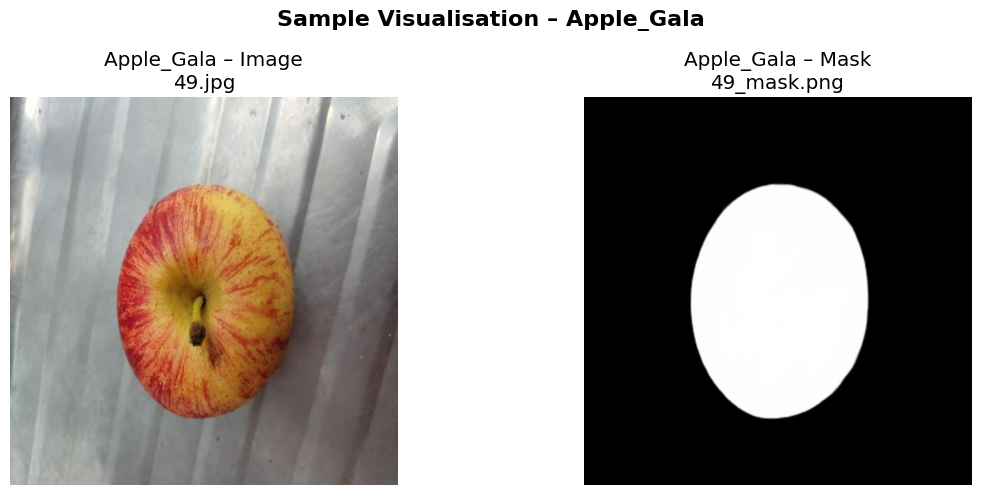



=== 🍎 Apple_Golden Delicious ===


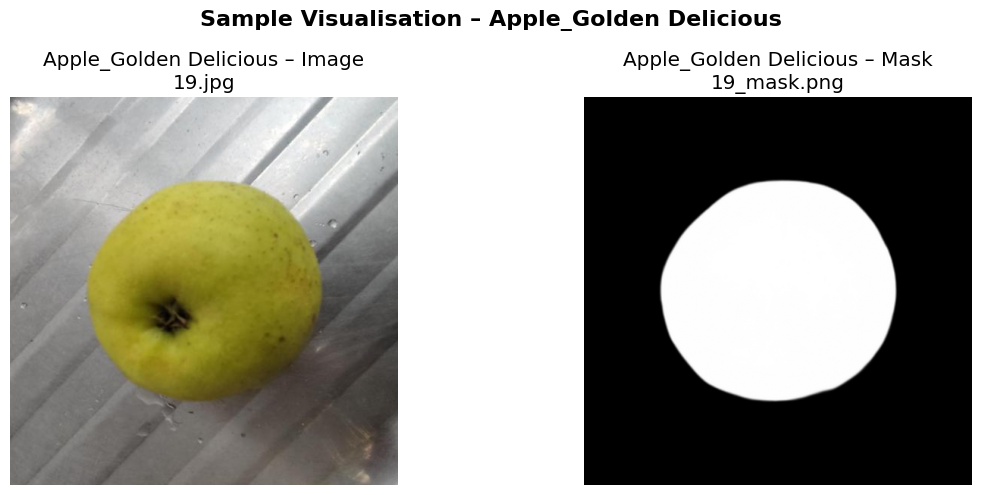



=== 🍎 Avocado ===


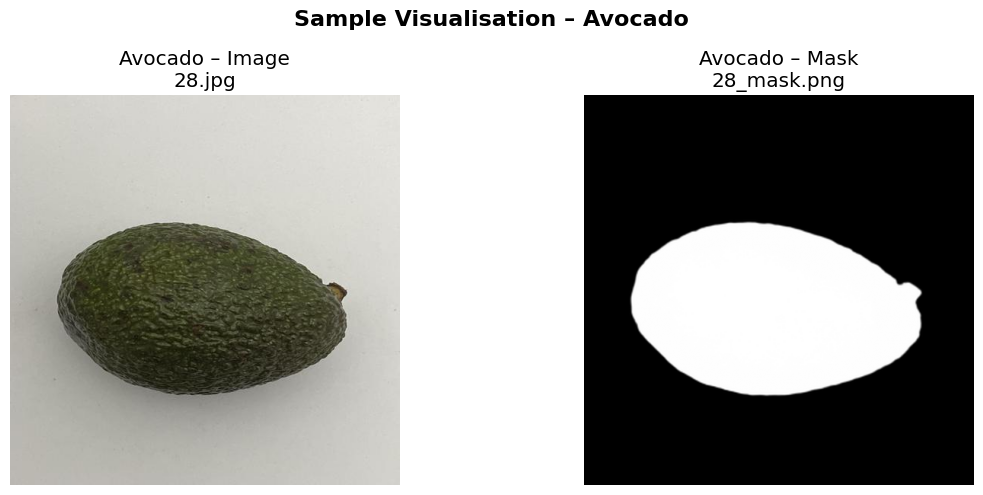



=== 🍎 Banana ===


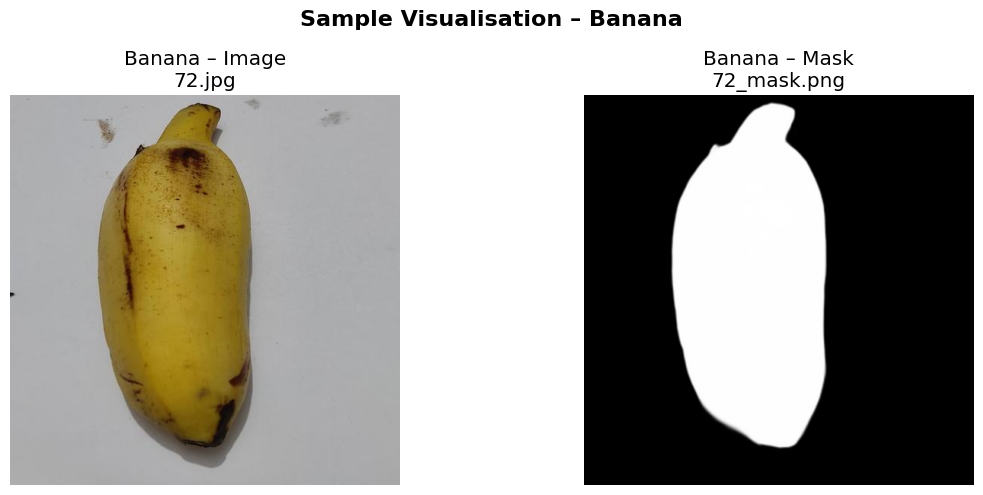



=== 🍎 Berry ===


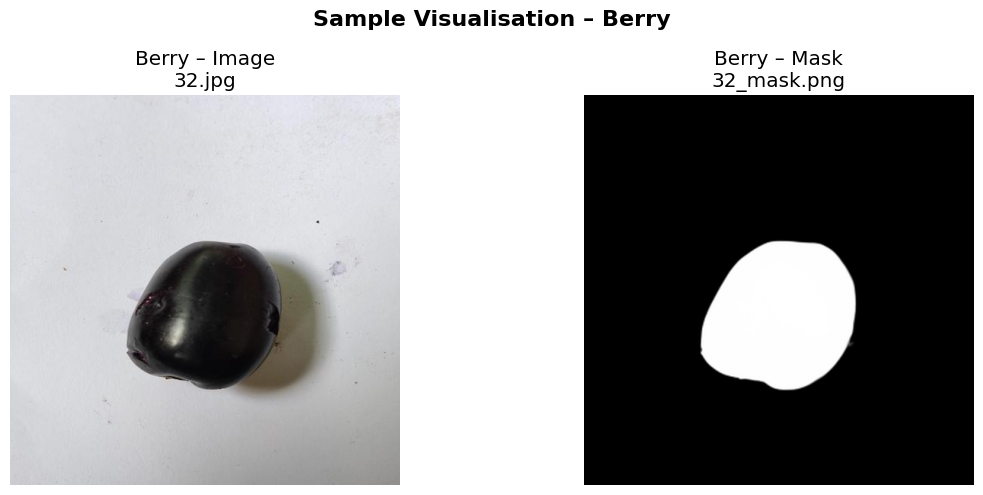



=== 🍎 Burmese Grape ===


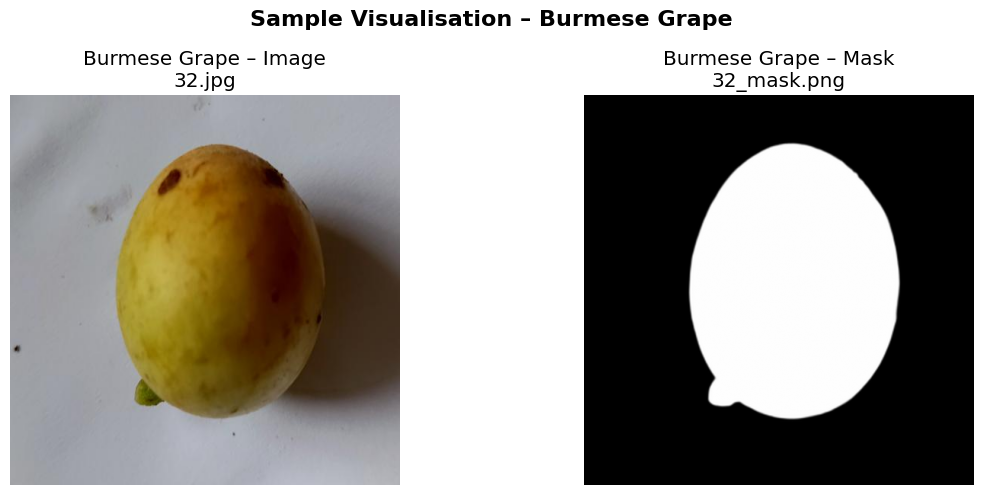



=== 🍎 Carambola ===


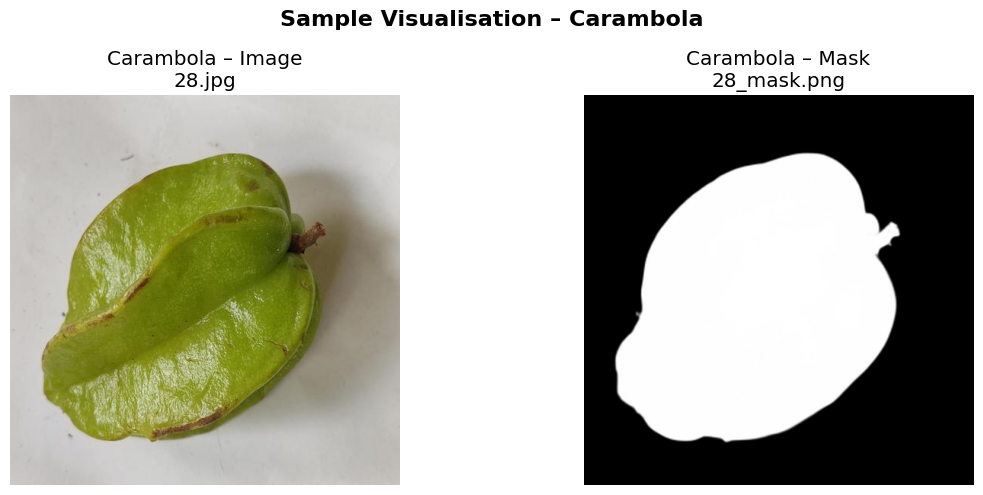



=== 🍎 Date Palm ===


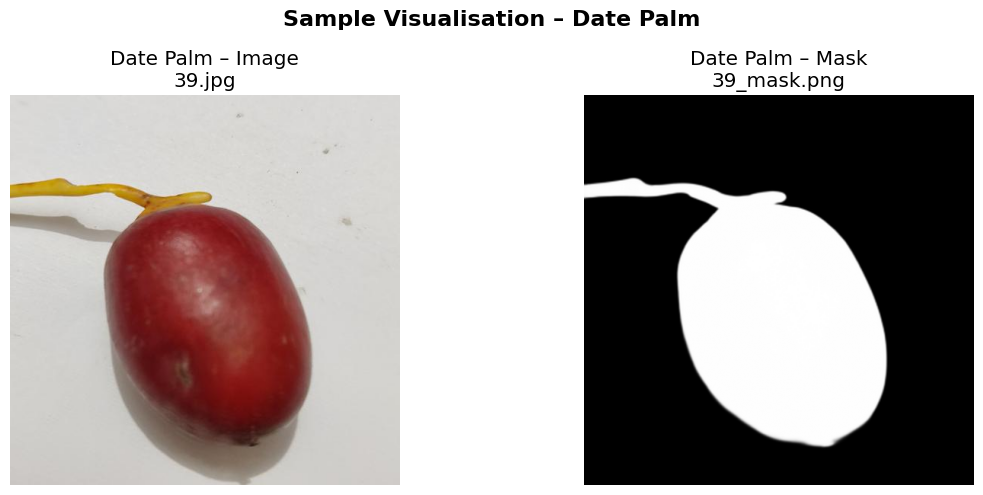



=== 🍎 Dragon ===


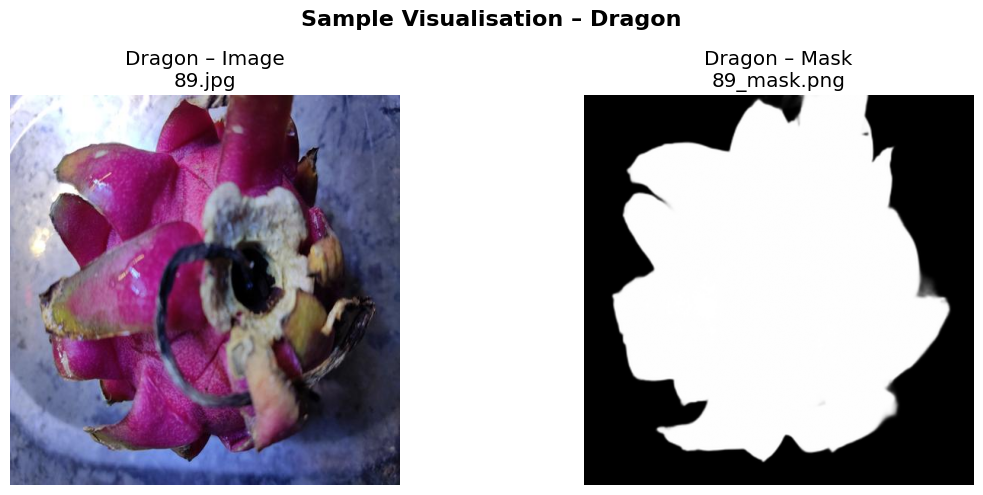



=== 🍎 Elephant Apple ===


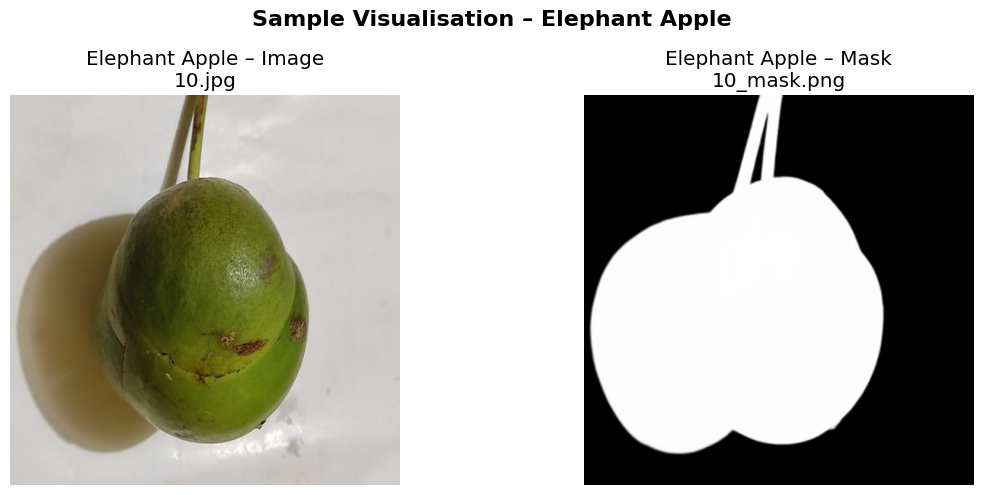



=== 🍎 Grape ===


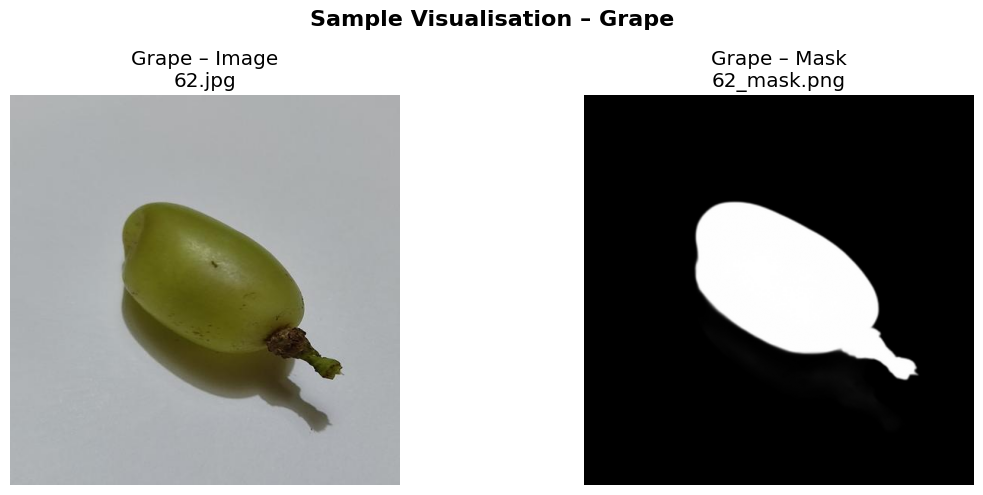



=== 🍎 Green Coconut ===


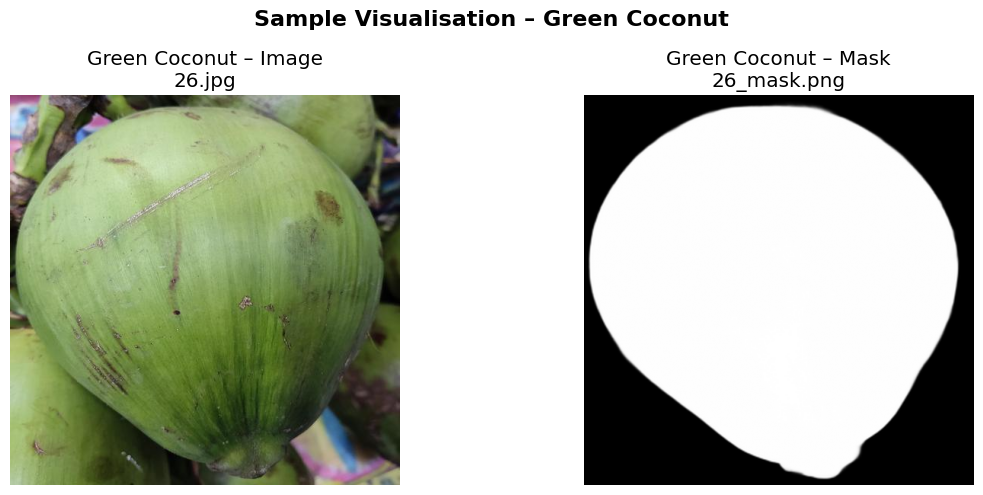



=== 🍎 Guava ===


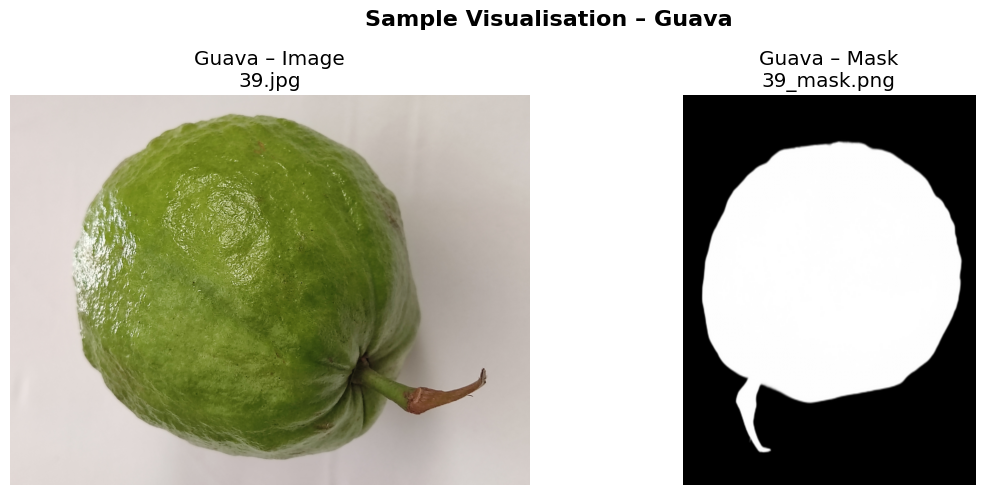



=== 🍎 Hog Plum ===


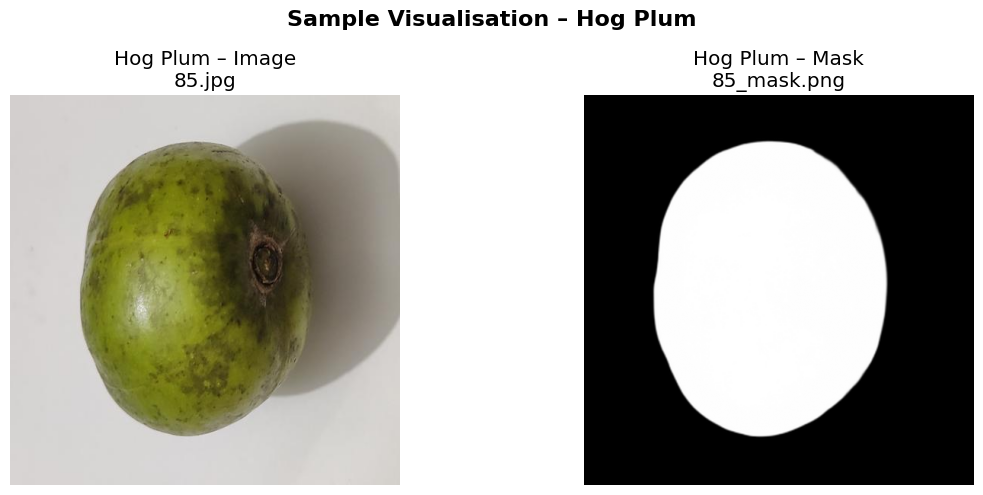



=== 🍎 Kiwi ===


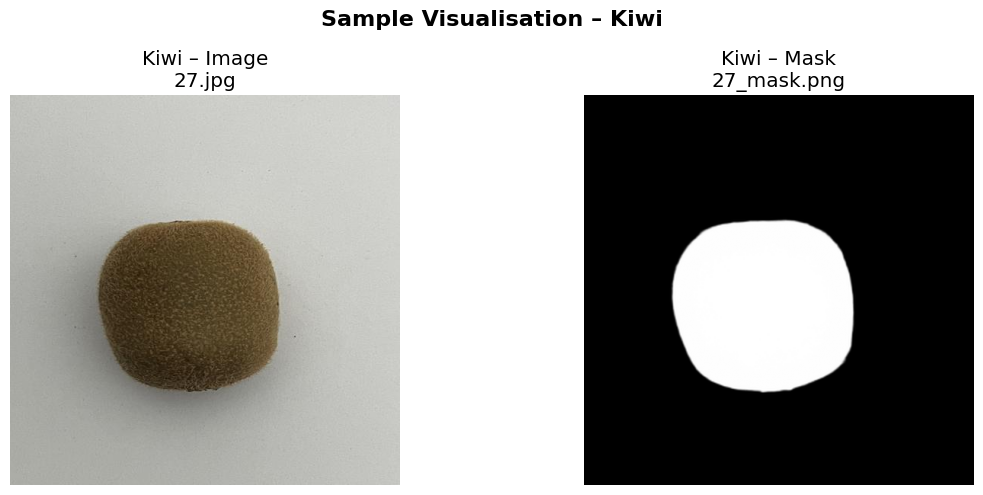



=== 🍎 Lichi ===


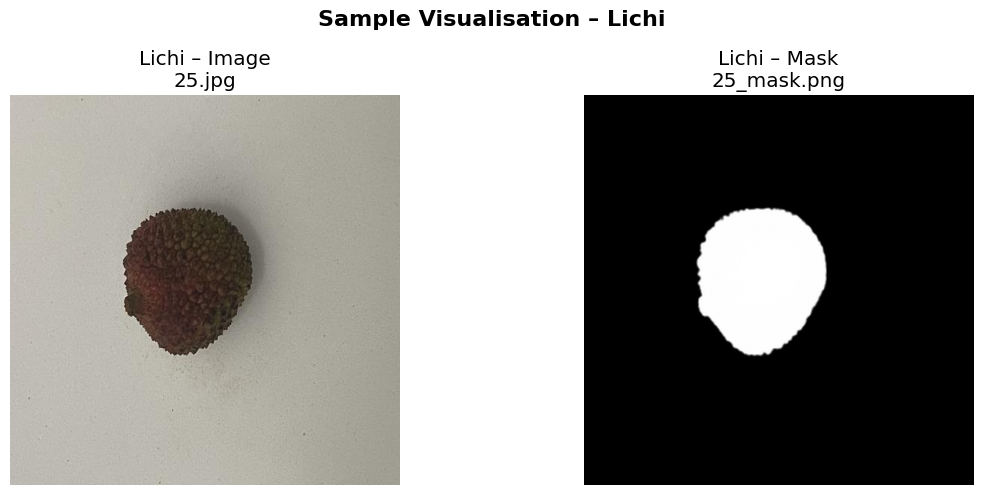



=== 🍎 Malta ===


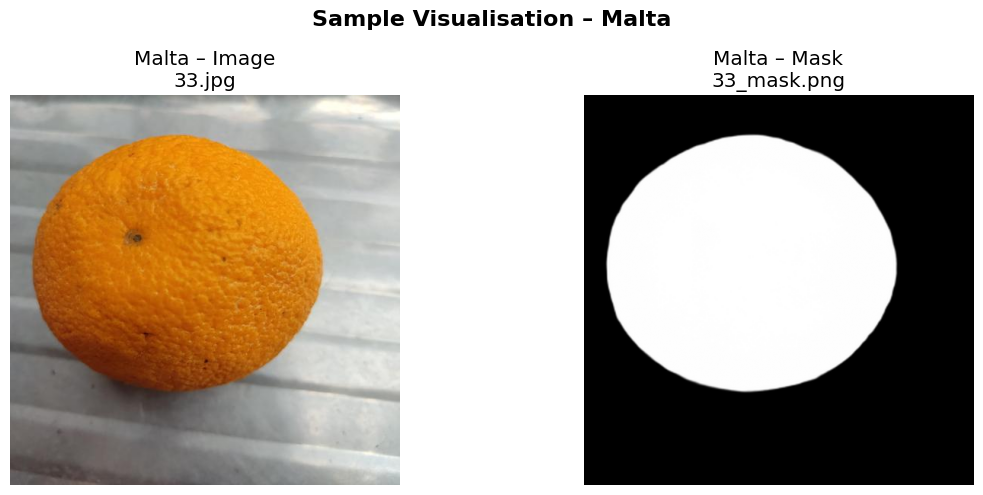



=== 🍎 Mango Golden Queen ===


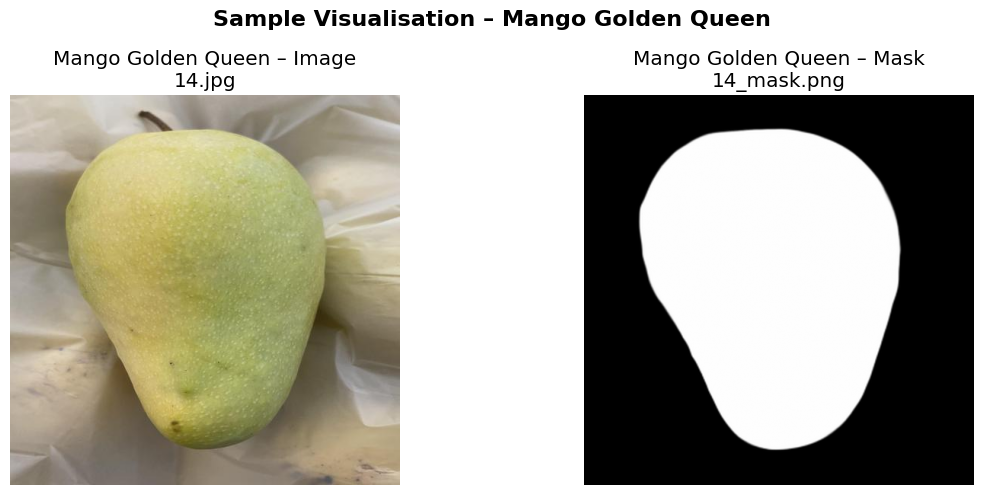



=== 🍎 Mango_Alphonso ===


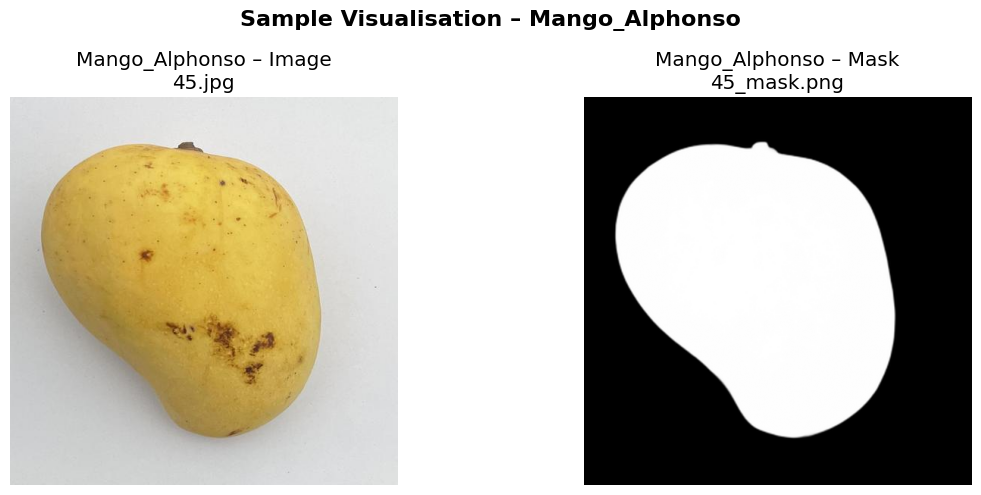



=== 🍎 Mango_Amrapali ===


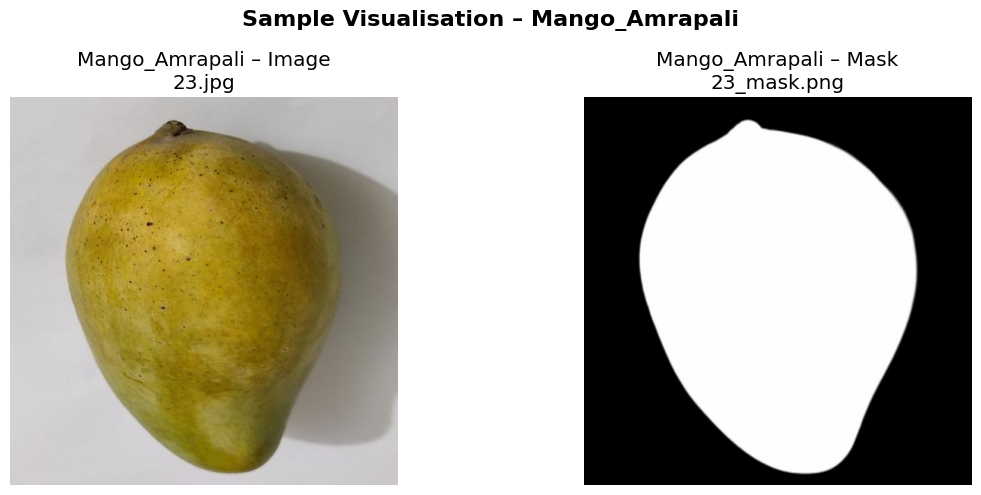



=== 🍎 Mango_Bari ===


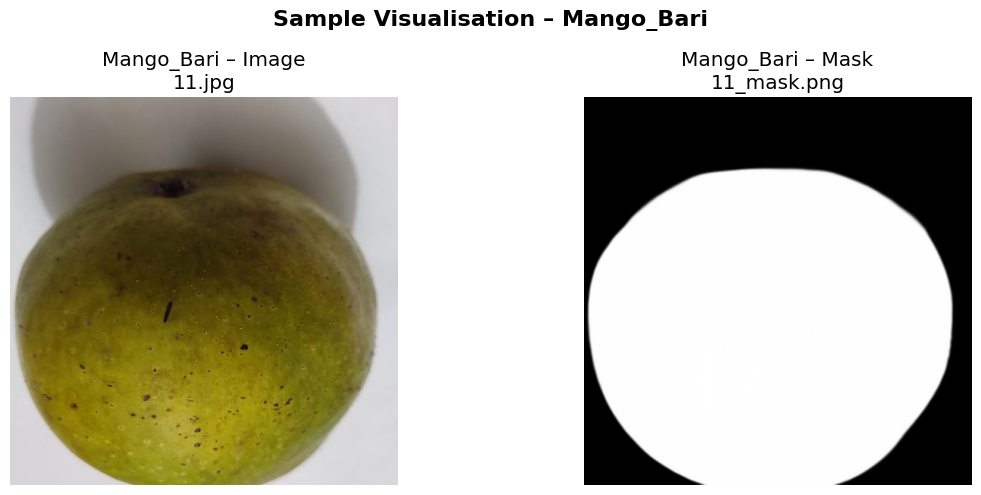



=== 🍎 Mango_Himsagar ===


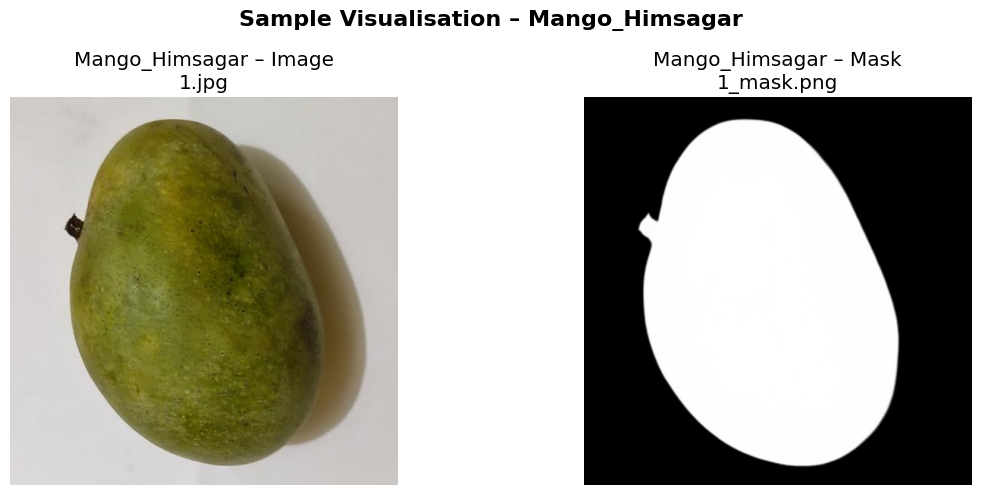



=== 🍎 Olive ===


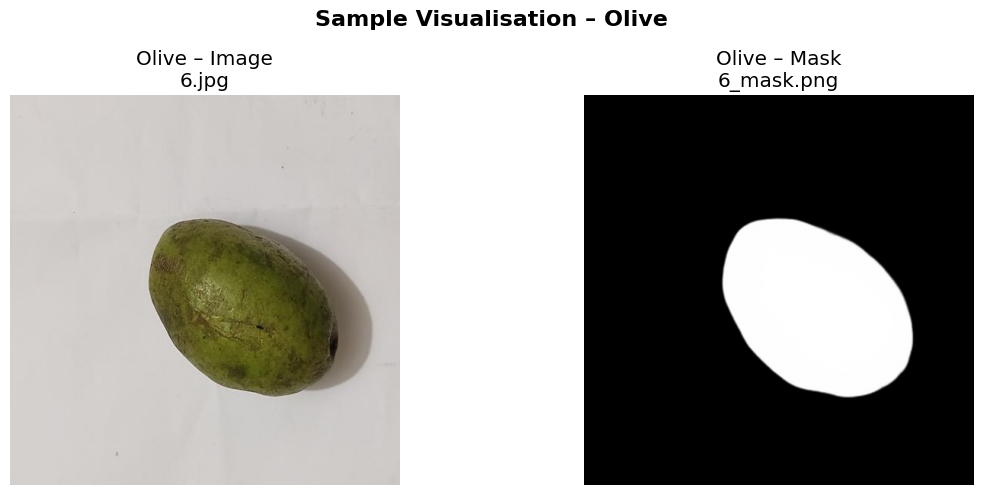



=== 🍎 Orange ===


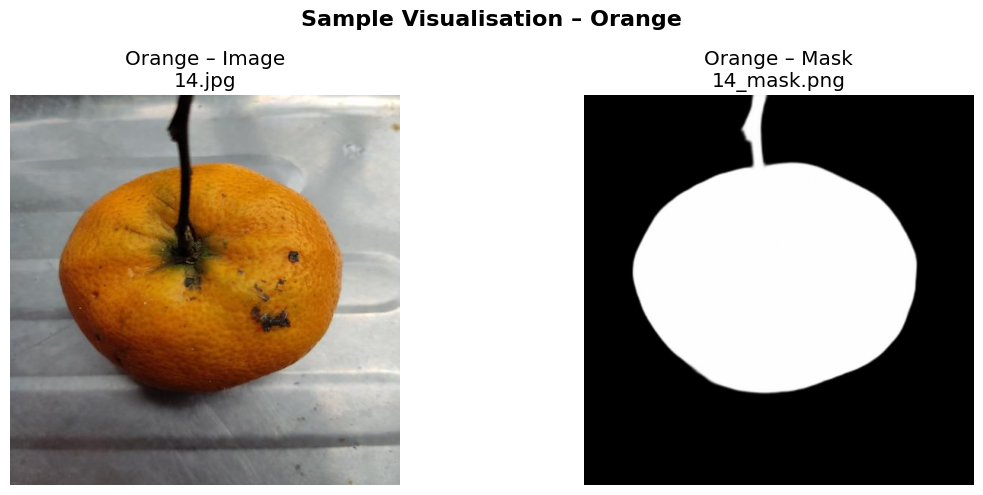



=== 🍎 Palm ===


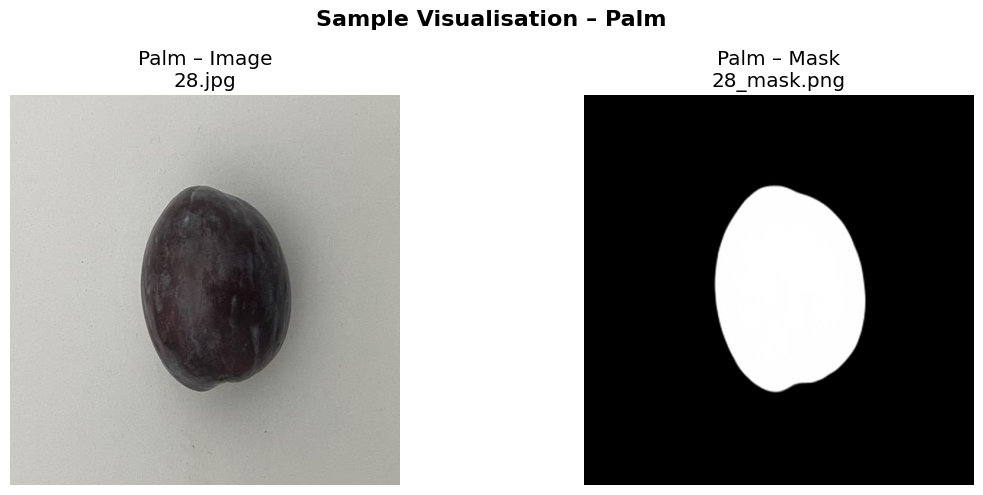



=== 🍎 Persimmon ===


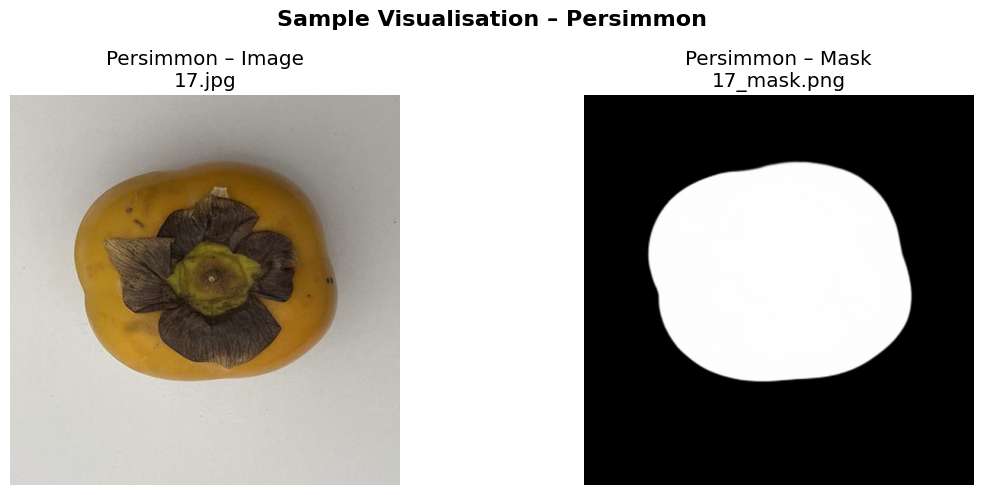



=== 🍎 Pineapple ===


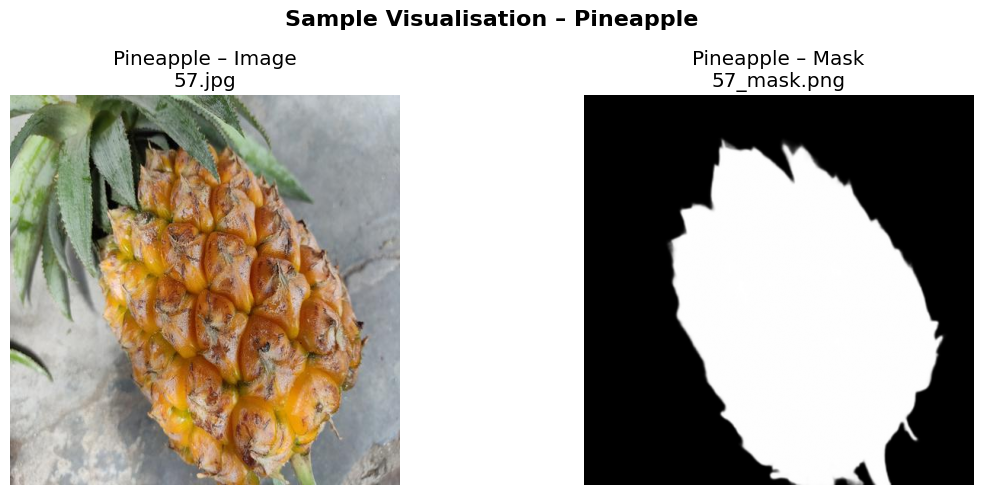



=== 🍎 Pomegranate ===


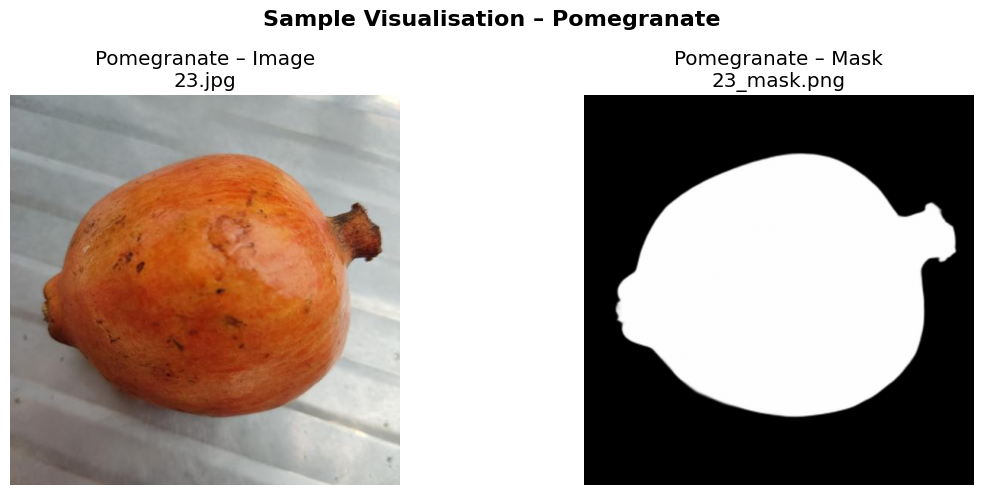



=== 🍎 Watermelon ===


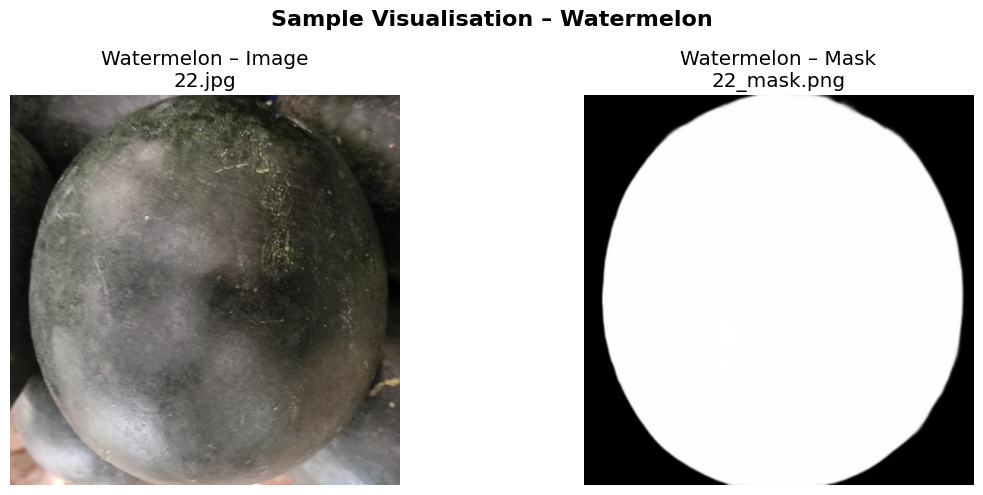



=== 🍎 White Pear ===


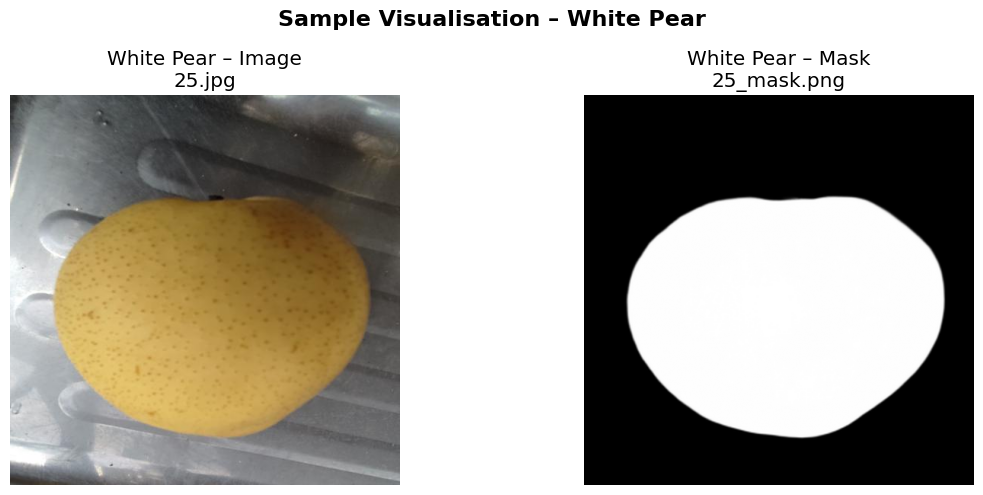

In [61]:
def visualize_all_fruits(datasets):
    if not datasets:
        print("❌ Tidak ada dataset buah.")
        return

    print(f"📊 Menampilkan sample untuk {len(datasets)} buah...\n")

    for fruit_dataset in datasets:
        fruit_name = fruit_dataset['fruit_name']
        print(f"=== 🍎 {fruit_name} ===")
        visualize_single_sample(fruit_dataset)
        print("\n")
        
visualize_all_fruits(datasets)



## Histogram channel (R,G,B)

Histogram digunakan dalam Exploratory Data Analysis (EDA) karena memberikan gambaran statistik mengenai distribusi intensitas warna pada gambar. Pada dataset segmentasi buah, histogram memiliki beberapa peran penting:

---

### **1. Memeriksa Kualitas Pencahayaan Gambar**

Histogram membantu melihat apakah gambar:

* terlalu gelap (*underexposed*),
* terlalu terang (*overexposed*),
* memiliki kontras kurang baik.

Hal ini penting agar model segmentasi tidak terganggu oleh variasi pencahayaan.

---

### **2. Mengidentifikasi Karakteristik Warna pada Buah**

Buah memiliki warna dominan, seperti:

* apel → merah / hijau
* pisang → kuning
* jeruk → oranye

Histogram RGB membantu memastikan bahwa warna objek terekam dengan baik dan tidak tertutup oleh warna background.

---

### **3. Mendeteksi Gambar Outlier atau Bermasalah**

Histogram memudahkan mendeteksi gambar yang:

* terlalu gelap/terang,
* memiliki saturasi tidak wajar,
* penuh noise,
* background mendominasi warna dan mengganggu objek.

Gambar semacam ini perlu dicek atau dibersihkan untuk meningkatkan kualitas dataset.

---

### **4. Validasi Kualitas Mask Segmentasi**

Pada mask biner, histogram seharusnya hanya menunjukkan dua nilai intensitas:

* **0 (background)**
* **255 (buah/objek)**

Jika histogram mask memperlihatkan banyak nilai selain itu, berarti terdapat:

* mask tidak bersih,
* ada area transparan atau semi-transparan,
* atau mask hasil segmentasi otomatis yang belum benar.

---

### **5. Membantu Menentukan Strategi Augmentasi**

Dari histogram, dapat ditentukan apakah dataset memerlukan:

* penyesuaian kecerahan (brightness),
* peningkatan kontras,
* color jitter,
* normalisasi warna tertentu.



In [56]:
def plot_rgb_histogram(image):
    img = np.array(image)

    colors = ('red', 'green', 'blue')
    plt.figure(figsize=(6, 4))

    for i, col in enumerate(colors):
        plt.hist(img[:,:,i].ravel(), bins=256, alpha=0.6, label=col, color=col)

    plt.title("RGB Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [57]:
def plot_grayscale_histogram(image):
    gray = np.array(image.convert("L"))

    plt.figure(figsize=(6, 4))
    plt.hist(gray.ravel(), bins=256, alpha=0.8)
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


In [58]:
def plot_mask_histogram(mask):
    mask_arr = np.array(mask)

    plt.figure(figsize=(6, 4))
    plt.hist(mask_arr.ravel(), bins=50)
    plt.title("Mask Histogram (Check Label Value)")
    plt.xlabel("Mask Pixel Value")
    plt.ylabel("Count")
    plt.show()


📸 Menampilkan sample...


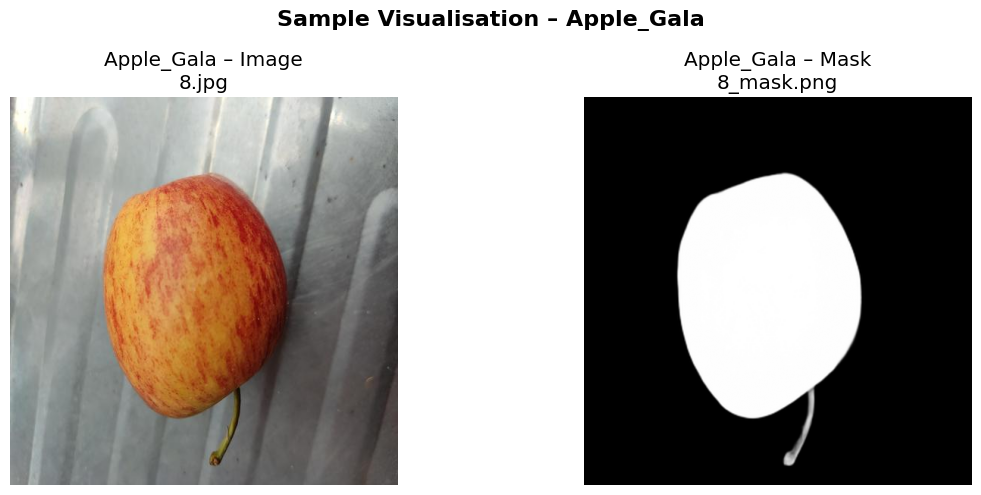


📊 RGB Histogram:
👉 Digunakan untuk melihat distribusi intensitas warna (R,G,B), memeriksa pencahayaan, warna dominan buah, dan mendeteksi gambar outlier.


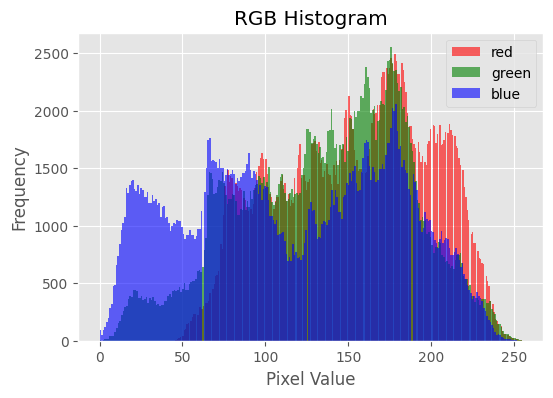


📊 Grayscale Histogram:
👉 Digunakan untuk melihat kontras keseluruhan, intensitas cahaya, dan kualitas brightness pada gambar.


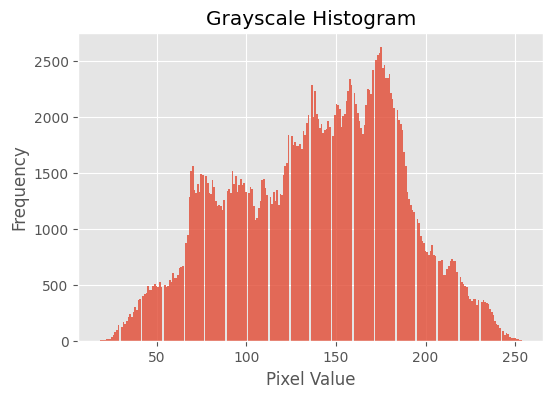


📊 Mask Histogram:
👉 Mask histogram digunakan untuk:
   - Memastikan mask bersifat biner (0 = background, 255 = objek).
   - Mengecek apakah ada nilai selain 0 dan 255 (mask rusak atau tidak bersih).
   - Mengukur seberapa besar area objek pada gambar dibanding background.
   - Mendeteksi mask kosong / salah pasangan.


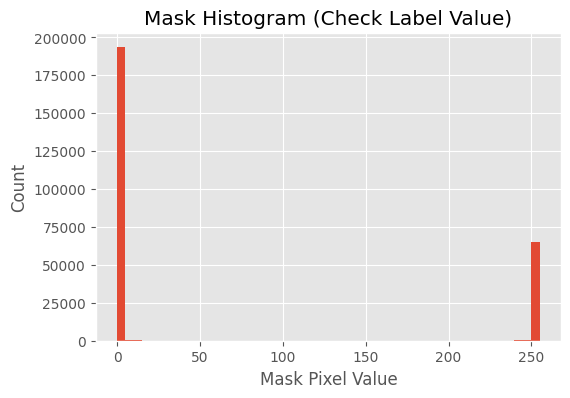

In [59]:
def visualize_all(fruit_dataset):
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    img_file = image_files[0]
    mask_file = mask_files[0]

    img = Image.open(os.path.join(images_path, img_file))
    mask = Image.open(os.path.join(masks_path, mask_file))

    print("📸 Menampilkan sample...")
    visualize_single_sample(fruit_dataset)

    print("\n📊 RGB Histogram:")
    print("👉 Digunakan untuk melihat distribusi intensitas warna (R,G,B), memeriksa pencahayaan, warna dominan buah, dan mendeteksi gambar outlier.")
    plot_rgb_histogram(img)

    print("\n📊 Grayscale Histogram:")
    print("👉 Digunakan untuk melihat kontras keseluruhan, intensitas cahaya, dan kualitas brightness pada gambar.")
    plot_grayscale_histogram(img)

    print("\n📊 Mask Histogram:")
    print("👉 Mask histogram digunakan untuk:")
    print("   - Memastikan mask bersifat biner (0 = background, 255 = objek).")
    print("   - Mengecek apakah ada nilai selain 0 dan 255 (mask rusak atau tidak bersih).")
    print("   - Mengukur seberapa besar area objek pada gambar dibanding background.")
    print("   - Mendeteksi mask kosong / salah pasangan.")
    plot_mask_histogram(mask)
    
visualize_all(datasets[0])
